# Stimulator Calibration Mouse in-vivo Recordings
#### by Katrin Franke based on Franke et al. 2019 and Qiu et al. 2021

This script allows estimating photoceptor excitation caused by a combination of light sources (e.g. LEDs) and dichroic filters used in a visual stimulator for in-vivo recordings. To this end, spectral data from an Ocean Optics spectometer is recorded via USB (i.e. with the USB2000+ spectrometer, Ocean Optics) and converted into photoisomerization rates per cone photoreceptor type and LED, taking into account (i) the wavelength specific transmission of the mouse optical apparatus and (ii) the ratio between pupil size and retinal area. 

The spectrometer measurements rely on the open source library [python-seabreeze](https://github.com/ap--/python-seabreeze) written by Andreas Pohlmann. This library is a wrapper for the C++ API provided by Ocean Optics. For installation instructions and further support, see there.

### Approach

Our approch consists of two main steps:

1. We first map electrical power ($P_{el}$, in $[W]$) to photon flux ($P_{Phi}$, in $[photons/s]$),  

   $$
   P_{Phi}(\lambda) = \frac{P_{el}(\lambda) \cdot a \cdot \lambda \cdot 10^{-9}} {c \cdot h }\cdot \frac{1}{\mu_{lens2cam}(\lambda)}.
   $$  

   For $\lambda$, we use the peak wavelength of the photoreceptor's spectral sensitivity curve ($\lambda_{S}=360 \: nm$, $\lambda_{M}=510 \: nm$). 
   
   The rest are constants ($a=6.2421018 \: eV/J$, $c=299,792,458 \: m/s$, and $h=4.135667 \cdot10^{-15} \: eV/s$). 
   

2. Next, we convert the photon flux to photoisomerisation rate ($R_{Iso}$, in $[P^*/cone/s]$),

  $$
  R_{Iso}(\lambda) = \frac{P_{Phi}(\lambda)}{A_{Stim}} \cdot A_{Collect} \cdot T(\lambda) \cdot R_{pup2ret}
  $$

  where $A_{Stim}$ is area that is iluminated on the power meter sensor, and $A_{Collect}=0.2 \: \mu m^2$ the photoreceptor's outer segment (OS) light collection area (see below).

  > Note: The OS light collection area ($[\mu m^2]$) an experimentally determined value, e.g. for wt mouse cones that are fully dark-adapted, a value of 0.2 is be assumed; for mouse rods, a value of 0.5 is considered realistic (for details, see [Nikonov et al., 2006](http://www.ncbi.nlm.nih.gov/pubmed/16567464)). 
  
  
Another factor we need to consider is the wavelength-dependent attenuation by the mouse eye optics. The relative transmission for UV ($T_{Rel}(UV)$, at $\lambda=360 \: nm$) and green ($T_{Rel}(G)$, at $\lambda=510 \: nm$) is approx. 35% and 55%, respectively ([Henriksson et al., 2010](https://pubmed.ncbi.nlm.nih.gov/19925789/)).


In addition, the light reaching the retina depends on the ratio ($R_{pup2ret}$) between pupil area and retinal area (both in $[mm^2]$) ([Rhim et al., 2020](https://www.biorxiv.org/content/10.1101/2020.11.03.366682v1)). Here, we assume pupil areas of $0.21 \: mm^2$ (stationary) and $1.91 \: mm^2$ (running) (see [Pennesi et al., 1998](https://pubmed.ncbi.nlm.nih.gov/9761294/)). To calculate the retinal area of the mouse, we assume an eye axial length of approx. $3 \: mm$ and that the retina covers about 60% of the sphere's surface ([Schmucker & Schaeffel, 2004](https://www.sciencedirect.com/science/article/pii/S0042698904001257#FIG4)).

In [1]:
import os
import glob
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.special as sse
import pylab
from scipy.optimize import curve_fit
from IPython import display

# Helpers
#
import scripts.spectrum as spc
import scripts.progress_bar as pbar
import scripts.spectrometer_helper as spm
import scripts.fitting_funcs as fit

# Set graphics to be plotted in the notebook
#
%matplotlib inline 

# Seaborn plot settings
#
sns.set()

# Paths and file names
# (Don't change unless you know what you are doing)
#
path_LightSources   = "light-sources//"
path_Filters        = "filters//"
path_SpectCalibData = "spectrometer-calibration-files//"
path_Data           = "data//"
path_Opsins         = "opsins//"
path_Transmission   = "transmission-mouse-eye//"
file_GammaLUT       = "defaultGammaLUT"

txtFileNewLineStr   = "\r\n"

def setPlotStyle():
    # Presettings for figures
    #
    mpl.rcParams['figure.figsize'] = [10, 5]
    mpl.rc('font', size=10)          
    mpl.rc('axes', titlesize=12)    
    mpl.rc('axes', labelsize=12)    
    mpl.rc('xtick', labelsize=12)   
    mpl.rc('ytick', labelsize=12)   
    mpl.rc('legend', fontsize=12)   
    mpl.rc('figure', titlesize=12) 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Define photoreceptors

Load opsin spectra from text files in the respective folder:

* Text files are expected to have one column per opsin ... 
* ... plus one (the last one) for the scaling in x direction (wavelength, in 1-nm increments).
* All spectral files, including the filter and LED files loaded later, must have the same x range. In this version, 300 .. 699 nm is used.

In [3]:
x_wavelen_nm = np.loadtxt(path_Opsins +"mouse_cone_opsins.txt", usecols=(2,)) # 300 .. 699 nm
mouseMOpsin  = np.loadtxt(path_Opsins +"mouse_cone_opsins.txt", usecols=(1,))
mouseSOpsin  = np.loadtxt(path_Opsins +"mouse_cone_opsins.txt", usecols=(0,))

Define some properties as well as constants needed later to convert the data measured with the spectrometer into photoisomerizations.

*   `h`: Planck's constant [eV*s]
*   `c`: speed of light [m/s]
*   `eV_per_J`: conversion factor ([eV] per [J])
*   `ac_um2`: cone OS light collection area [µm^2], see [Nikonov et al., 2006] (http://www.ncbi.nlm.nih.gov/pubmed/16567464) for details. This is an experimentally determined value, e.g. for wt mouse cones that is fully dark-adapted, a value of 0.2 can be assumed.
*   `ar_um2`: rod OS light collection area, see above. A value of 0.5 is considered realistic.   
    

In [4]:
h        = 4.135667E-15 # Planck's constant [eV*s]
c        = 299792458    # speed of light [m/s]
eV_per_J = 6.242E+18    # [eV] per [J]
ac_um2   = 0.2     
ar_um2   = 0.5

Organise photoreceptors as a list of dictionaries, with:

*   `name`: name of photoreceptor, used later for plots etc.
*   `peak_nm`: peak wavelength of opsin spectrum in [nm]          
*   `collecArea_um2`: see above
*   `spect`: opsin spectrum

In [5]:
MCone = {"name"           : "mouse_M_cone",
         "peak_nm"        : 511,
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseMOpsin}
SCone = {"name"           : "mouse_S_cone",
         "peak_nm"        : 360,         
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseSOpsin}
Rod   = {"name"           : "mouse_rod",
         "peak_nm"        : 510,         
         "collecArea_um2" : ar_um2, 
         "spect"          : []}

PRs   = [MCone, SCone, Rod]

Plot cone photoreceptor spectra:

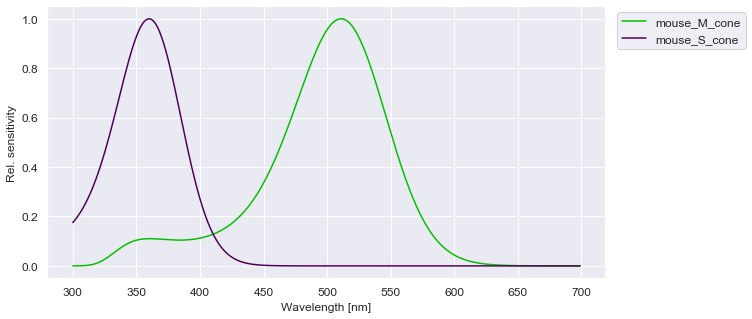

In [6]:
setPlotStyle()

for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        plt.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

plt.gca().set(xlabel="Wavelength [nm]", ylabel="Rel. sensitivity") 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

## Define stimulus LED/filter combinations 
Load LED and filter (dicroic) spectra from text files in the respective folder. Files are expected to be organised as the photoreceptor data files except that they contain only two columns (relative transmission for filters and relative intensity for light sources; wavelength, from 300 to 699 nm in 1-nm increments).

In [7]:
# LED spectra
#
LED_Blue_Name  = "LED_Blue"
LED_Blue       = np.loadtxt(path_LightSources +LED_Blue_Name +".txt", usecols=(0,))
LED_UV_Name     = "LED_UV"
LED_UV          = np.loadtxt(path_LightSources +LED_UV_Name +".txt", usecols=(0,))

#### Decide, if one filter per LED is used, if a dual-band filter is used, or if no filter is used.  

In [8]:
LEDFilterType = 2  # 0=individual for each LED, 1=dual-band filter, 2=no filters used

In [9]:
# LED filter(s)
#
if LEDFilterType == 0:
    Filter_UV_Name      = "Filter_387_11"
    Filter_UV           = np.loadtxt(path_Filters +Filter_UV_Name +".txt", usecols=(0,))
    Filter_Green_Name   = "Filter_576_10"
    Filter_Green        = np.loadtxt(path_Filters +Filter_Green_Name +".txt", usecols=(0,))
elif LEDFilterType == 1:
    Filter_UVGreen_name = "Filter_F59-003_390_575"
    Filter_UV           = np.loadtxt(path_Filters +Filter_UVGreen_name +".txt", usecols=(0,))
    Filter_Green        = np.loadtxt(path_Filters +Filter_UVGreen_name +".txt", usecols=(0,))
elif LEDFilterType == 2:
    Filter_UV      = np.array(list([1.0]*len(LED_UV)))
    Filter_Blue   = np.array(list([1.0]*len(LED_UV)))

#### Decide if LEDs are used, or a standard TFT screen:

In [10]:
LightSourceType = 0 # 0=LEDs, 1=TFT screen

Organise the LED/filter combinations and spectra as a list of dictionary, with:  
*   `name`: name of LED/filter combinations, used later for plots etc.
*   `peak_nm`: peak wavelength of LED/filter combination in [nm]          
*   `LED_spect`: spectrum of LED (same x range as the opsin spectra, that is from 300 to 699 nm, and with 1-nm resolution).
*   `filter_spect`: spectrum of filter
*   `spect_nw`: measured LED/filter spectrum in [nW]
*   `spect_nw_norm`: `spect_nw` peak-normalized
*   `spect_raw_bkg`: mean background spectrum (LED off)
*   `spect_raw`: temporary spectra of LED/filter (all trials) for the current intensity level
*   `spect_raw_avg`: list of mean spectra of LED/filter for all intensity levels
*   `spect_raw_fit`: list of fits of mean LED/filter spectra for all intensity levels

In [11]:
minWLen_nm              = 300
maxWLen_nm              = 699
n                       = maxWLen_nm -minWLen_nm +1
x_wavelen_nm            = np.array([v+minWLen_nm for v in range(n)], dtype=np.float64)
LightSourceType         = 0 # 0 for LEDs, 1 for TFT monitor

if LightSourceType == 0:
    # In vivo setup, UV-green-blue LCr 
    #
    BlLED = {"name"         : "blue",
             "peak_nm"      : 460,          # 0=determine from peak
             "target_PR"    : "mouse_M_cone",
             "bandwidth_nm" : 0,            # obsolete
             "LED_spect"    : LED_Blue,    # LED spectrum (datasheet)
             "filter_spect" : Filter_Blue, # filter spectrum (datasheet)
             "meas_n_trials": [1, 1],     # trials to measure for LED off and on
             "spect_nw_norm": None,   
             "spect_nw"     : None,   
             "spect_raw_bkg": None,   
             "spect_raw"    : None,   
             "spect_raw_fit": None,   
             "spect_raw_avg": None}   

    UVLED = {"name"         : "UV",
             "peak_nm"      : 395,
             "target_PR"    : "mouse_S_cone",
             "bandwidth_nm" : 0,
             "LED_spect"    : LED_UV,
             "filter_spect" : Filter_UV,
             "meas_n_trials": [1, 1],         
             "spect_nw_norm": None,
             "spect_nw"     : None,        
             "spect_raw_bkg": None,
             "spect_raw"    : None,
             "spect_raw_fit": None,
             "spect_raw_avg": None}
    LEDs = [BlLED, UVLED]         
    
elif LightSourceType == 1:    
    # TFT screen, for comparison
    #
    GrLED = {"name"         : "green",
             "peak_nm"      : 520,          # 0=determine from peak
             "bandwidth_nm" : 0,            # obsolete
             "target_PR"    : "mouse_M_cone",
             "LED_spect"    : [],           # LED spectrum (datasheet)
             "filter_spect" : [],           # filter spectrum (datasheet)
             "meas_n_trials": [2, 2],       # trials to measure for LED off and on
             "spect_nw_norm": None,   
             "spect_nw"     : None,   
             "spect_raw_bkg": None,   
             "spect_raw"    : None,   
             "spect_raw_fit": None,   
             "spect_raw_avg": None}   

    BlLED = {"name"         : "blue",
             "peak_nm"      : 450,
             "bandwidth_nm" : 0,
             "target_PR"    : "mouse_S_cone",
             "LED_spect"    : [],
             "filter_spect" : [],
             "meas_n_trials": [2, 2],
             "spect_nw_norm": None,
             "spect_nw"     : None,        
             "spect_raw_bkg": None,
             "spect_raw"    : None,
             "spect_raw_fit": None,
             "spect_raw_avg": None}

    ReLED = {"name"         : "red",
             "peak_nm"      : 650,
             "bandwidth_nm" : 0,
             "target_PR"    : "mouse_M_cone",
             "LED_spect"    : [],
             "filter_spect" : [],
             "meas_n_trials": [2, 2],
             "spect_nw_norm": None,
             "spect_nw"     : None,        
             "spect_raw_bkg": None,
             "spect_raw"    : None,
             "spect_raw_fit": None,
             "spect_raw_avg": None}
    LEDs  = [ReLED, GrLED, BlLED]

Plot theoretical spectra of LED/filter combinations together with cone photoreceptors:

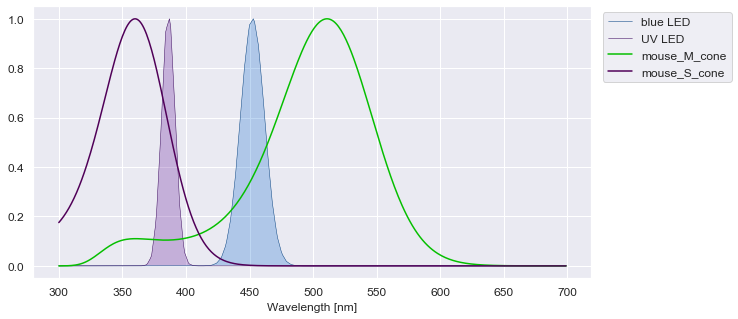

In [12]:
for LED in LEDs:  
    if len(LED["LED_spect"]) == 0: 
        continue
    
    col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    plt.plot(x_wavelen_nm, LED["LED_spect"], color=col_lo, 
            label=LED["name"] +" LED", linewidth=0.5)
    plt.fill(x_wavelen_nm, LED["LED_spect"], facecolor=col_hi, alpha=0.25) 
    if LEDFilterType != 2:
        plt.plot(x_wavelen_nm, LED["filter_spect"], color="black", 
            label=LED["name"] +" filter", linewidth=1)
    
for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        plt.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

plt.gca().set(xlabel="Wavelength [nm]", ylabel="") 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

## Spectrometer measurements
This section allows measuring the light sources (e.g. LEDs) using a spectrometer. The measured data is stored in the data path (for details, see below) and can also be re-loaded instead of performing a measurement. This way, notebooks can be reproduced based on the stored spectral data.

### Import calibration file for spectrometer
For each wavelength, the file contains corresponding [µJ/count] correlation, which will be used to calibrate the readings from the spectrometer.  
*__Note:__ These files need to be obtained for each individual device.*

In [13]:
spm_fileName          = path_SpectCalibData + "Cal_F00079_20191003.txt" 
spm_serialNumber      = "USB2+F00079"
correction_factor     = 50 # estimated using a calibrated spectrometer and a power meter
spm_calib_values      = np.loadtxt(spm_fileName, usecols=(0,))*correction_factor
spm_calib_wavelengths = np.loadtxt(spm_fileName, usecols=(1,))

Plot spectometer calibration curve

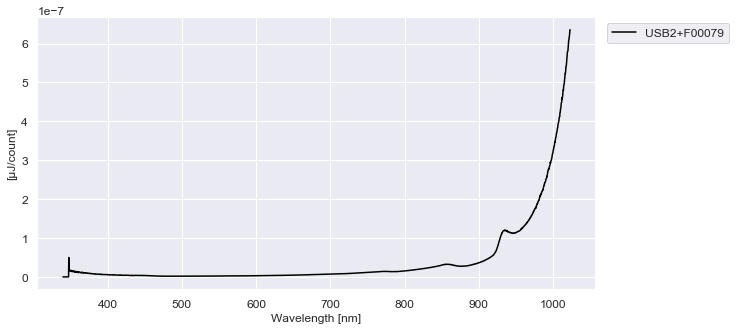

In [14]:
plt.plot(spm_calib_wavelengths, spm_calib_values, color="black", label=spm_serialNumber)
plt.gca().set(xlabel="Wavelength [nm]", ylabel="[µJ/count]")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


### Define measurement parameters
For the measurement and later for the calculation of photoisomerization rates, the area (`A_detect_um2`) of the measured light spot -- or, if it overfills the sensor of the spectrometer, the area of the sensor (e.g. the diffusor window of the spectrometer) -- is needed. Also required is the integration time (`int_time_s`) of the spectrometer.  


*__Note:__ In case of the Ocean Optics USB2000 used here, the area of the diffusor window is 0.113411cm².*  
*__Note:__ The integration time should be changed if output is saturated. To obtain [µJ/s] with the USB2000, use 1 s.*

In [15]:
if LightSourceType == 0:
    # LEDs of LCr
    int_time_s    = 0.1
    r_stimulus_um = 300

elif LightSourceType == 1:
    # TFT screen, for comparison
    int_time_s    = 1.0
    r_stimulus_um = 1900 

# Calculations illuminated area
A_detect_um2 = np.pi*(r_stimulus_um)**2
print("Illuminated area is {0:.3e} µm2 (= {1:.3} cm²)".format(A_detect_um2, A_detect_um2 *1E-8))

Illuminated area is 2.827e+05 µm2 (= 0.00283 cm²)


Define stimulus conditions via step size, then the full range (`0 .. 255`) will be used, or, alternatively, by selecting the intensity steps directly, e.g.:  
`stim_intens = [0,200,255]` (in this case, `stim_intens_step_size = 0`)

In [16]:
stim_intens_step_size = 0
stim_intens           = [255]

# Some calculations ...
#
if stim_intens_step_size > 0:
    stim_n_intens_levels = int(255 /stim_intens_step_size +1)
    stim_intens = [stim_intens_step_size*i for i in range(0, stim_n_intens_levels)]
else:
    stim_n_intens_levels = len(stim_intens)
    
stim_intens = np.array(stim_intens)
use_trigger = stim_n_intens_levels > 1

print("{0} intensity step(s):".format(stim_n_intens_levels)) 
print(stim_intens)

1 intensity step(s):
[255]


Estimate the fraction of the screen covered by the optical fiber of the spectrometer based on the distance to the screen and the acceptance angle of the fiber:

In [33]:
angle_fiber = 25 # in degrees
radians_fiber = angle_fiber*np.pi / 180
distance = 12 # in centimeters
radius_screen_fiber = np.tan(radians_fiber)*distance
fiber_area = np.pi*(radius_screen_fiber**2)

screen_x = 43 # in centimeters
screen_y = 26 # in centimeters
screen_area = screen_x * screen_y

# estimate a factor correcting for the fraction of the screen covered by the spectrometer
coverage_correction = screen_area/fiber_area

### Connect and setup the spectrometer
Select the device using its serial number and set the integration time in [s].   

In [34]:
spm.connect(spm.DevType.OO_USB2000, spm_serialNumber, int_time_s, use_trigger)            

ERROR: No device attached with serial number 'USB2+F00079'.


### Record (or load) spectra of light sources
Prepare the measurements and when ready, press Enter. For each LED (light source), first the background spectrum (i.e. LED off) and then the spectra for all selected intensity are recorded. 

The recorded mean spectra together with the wavelengts are written to a text file, one per LED. By chosing the name of an existing set of files (`fileNameMask`) in the folder `data//`, no measurements are taking place and instead the data of that earlier recording is loaded.

### Examples

`LEDs_Setup2_20180821` - Measurement of the intensity curve (128 levels, from 0 to 254 in steps of 2) for the UV and the green LED to estimate the gamma correction look-up table (LUT, `defaultGammaLUT.txt`). Note that the LED power was increased compare to the normal experimental conditions (i.e. retina recordings) to yield spectrometer readings in the low level range. 

`LEDs_Setup2_20180823` - Measurement of the intensity curve (128 levels, from 0 to 254 in steps of 2) for the UV and the green LED **with gamma-correction** applied. Note that like for `LEDs_Setup2_20180821`, the LED power was increased compare to the normal experimental conditions (i.e. retina recordings) to yield spectrometer readings in the low level range.

`LEDs_Setup2_20190130` - Measurement of maximal intensity (only level 255) of the UV and the green LED **after adjusting LED power** to the range used for retina recordings. 

`TFTMonitor_Samsung_4` - Measurement of a random TFT monitor.

In [35]:
# Examples
#
if LightSourceType == 0:
    fileNameMask  = "LEDs_LCr_20191108_0" # LCr LEDs
elif LightSourceType == 1:
    fileNameMask  = "TFT_Monitor_20191003_0" # Standard TFT screen, for comparison

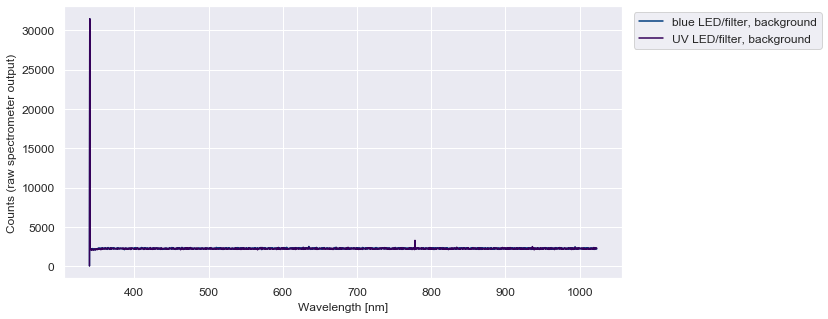

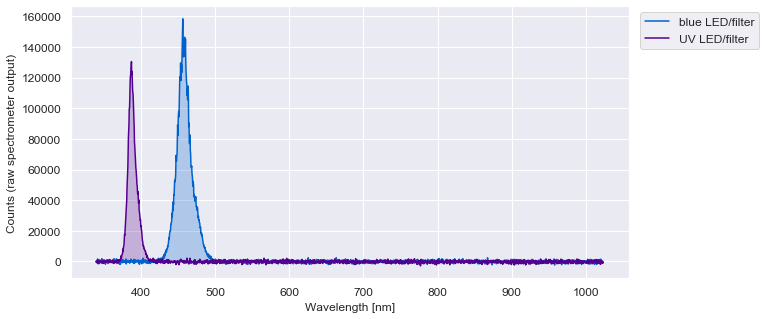

In [36]:
for iLED, LED in enumerate(LEDs):
    # At first, use colors that are defined for the current LED
    #
    col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    
    # Generate file name
    #
    fName  = "{0}{1}_{2}.csv".format(path_Data, fileNameMask, LED["name"])
    isLoad = os.path.isfile(fName)
    if isLoad:
        # File for that LED exists, load spectral data
        #
        wavelengths, LED["spect_raw_bkg"],  LED["spect_raw_avg"], stim_intens = spc.loadSpectData(fName) 
        
    else:
        # Measure LED background ...
        #
        input("Measure background of {0} LED. Press Enter to start ...".format(LED["name"]))
        curr_background = []    
        for i in pbar.log_progress(range(LED["meas_n_trials"][0]), name='Background, {0} LED'.format(LED["name"])):
            wavelengths, intensities = spm.grabSpectrum(spm.DevType.OO_USB2000, 0)
            curr_background.append(intensities)
        LED["spect_raw_bkg"] = np.mean(curr_background, axis=0)

    # Plot ...
    #
    plt.figure(1)  
    plt.plot(wavelengths, LED["spect_raw_bkg"], color=col_lo, label=LED["name"] +" LED/filter, background")
    plt.gca().set(xlabel="Wavelength [nm]", ylabel="Counts (raw spectrometer output)")     
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if not(isLoad):
        # Measure LED at the selected intensities ...    
        #
        LED["spect_raw_avg"] = []
        nIntensFound         = 0
        tempText             = "{0} LED/filter for intensity step".format(LED["name"])
        input("Measure {0} LED . Press Enter to start ...".format(LED["name"]))
        for iI in range(stim_n_intens_levels):
            curr_spectrum    = []
            LED["spect_raw"] = []
            for iT in range(LED["meas_n_trials"][1]):
                wavelengths, intensities = spm.grabSpectrum(spm.DevType.OO_USB2000, 0)
                curr_spectrum = intensities - LED["spect_raw_bkg"]
                LED["spect_raw"].append(curr_spectrum)
            LED["spect_raw_avg"].append(np.mean(LED["spect_raw"], axis=0))   
            nIntensFound += 1
    
    # Correct spectrum by coverage factor
    #
    curr_spectrum = LED["spect_raw_avg"]
    LED["spect_raw_avg"] = [i * coverage_correction for i in curr_spectrum]
    
    # Plot ...
    #
    
    for iI, Intens in enumerate(stim_intens):            
        plt.figure(2) 
        tempLbl = LED["name"] +" LED/filter" if iI == 0 else ""
        plt.plot(wavelengths, LED["spect_raw_avg"][iI], color=col_hi, label=tempLbl)
        plt.fill(wavelengths, LED["spect_raw_avg"][iI], facecolor=col_hi, alpha=0.25)        
        plt.gca().set(xlabel="Wavelength [nm]", ylabel="Counts (raw spectrometer output)")     
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   

    display.display(plt.gcf())
    display.clear_output(wait=True)
    
if len(glob.glob("{0}{1}_*".format(path_Data, fileNameMask))) == 0:
    # Save all measured data and disconnect spectrometer
    #
    #spc.saveAllSpectData(fileNameMask, path_Data, wavelengths, LEDs, stim_intens)
    spm.disconnect(spm.DevType.OO_USB2000)

### Postprocess the spectra
If the LEDs are dim and the spectral measurements are noisy, the spectra can be cleaned up by removing "shot noise" and fitting the raw spectra. The available fit functions are a normal Gaussian (`Gauss()`) and an exponentially modified Gaussian (`EMG()`; see `scripts//fitting_funcs.py`). More fit functions can be defined by the user, if needed. 

The function `removeShotNoise()` replaces single data points by the trace average if the datapoints are very (>`lim`) different from their direct neighboring datapoints.

The postprocessing includes the following steps:
1. `useFit` select the fit function (or none), with `0`=no, `1`=use Gaussian, `2`=use EMG
2. `useSNRemover`, 1=try removing shot noise using the threshold `SN_thres`
3. `sigmaStart` is the starting width for the Gaussian or EMG fit
4. `useRange_nm` is only considering this nm range around the peak of the spectrum, this is helpful as shorter wavelengths can introduce noise when multiplied with the calibration file

Typical parameters for LED measurements are `useFit=1`, `useSNRemover=1`, `SN_thres=50`, and `sigmaStart=1`.  
For an RGB TFT screen, typical parameters are `useFit=2`, `useSNRemover=0`, `SN_thres=500`, and `sigmaStart=1`.


In [37]:
if LightSourceType == 0:
    # Setup #2 green-UV lightcrafter 
    # (through-the-condenser stimulation)
    #
    useFit             = 0  # 0=no, 1=use Gaussian, 2=use exponentially modified Gaussian (EMG)
    useSNRemover       = 1  # 0=no, 1=yes
    useLEDPeak         = 0  # 0=determine peak, 1=use peak given in the LED description
    useRange_nm        = 0  # if > 0, considers only the spectrum the range around the peak
    useBaselineToZero  = 1  # 0=no, 1=yes, 
    Baseline_thres     = 3  # std of baseline
    SN_thres           = 50 # threshold for shot noise detection, 
    sigmaStart         = 1
    
else:    
    # TFT screen, for comparison
    #
    useFit       = 2
    useSNRemover = 1  
    useLEDPeak   = 1
    useRange_nm  = 0 
    SN_thres     = 500
    sigmaStart   = 1

for iLED, LED in enumerate(LEDs):
    LED["spect_raw_fit"] = []
    
    for iI, Intens in enumerate(stim_intens):
        x     = wavelengths
        y     = LED["spect_raw_avg"][iI]
        ampl  = y.max()
        mean  = LED["peak_nm"] if useLEDPeak else x[np.argmax(y)] 
        sigma = sigmaStart
        tau   = 1
        
        if useSNRemover > 0:
            # Try removing shot noise
            #
            LED["spect_raw_avg"][iI] = fit.removeShotNoise(LED["spect_raw_avg"][iI], SN_thres)
            
        if useFit > 0:
            # Fit the measured curves
            #
            warnings.filterwarnings(action='ignore')
            try:
                if useFit == 1:
                    popt, pcov = curve_fit(fit.Gauss, x, y, p0=[ampl, mean, sigma])
                    y_fit = fit.Gauss(x, popt[0], popt[1], popt[2])
                elif useFit == 2:
                    popt, pcov = curve_fit(fit.EMG, x, y, p0=[ampl, mean, sigma, tau])
                    y_fit = fit.EMG(x, popt[0], popt[1], popt[2], popt[3])
            except RuntimeError:
                # Error, try simple Gaussian fit ...
                #
                try:
                    popt, pcov = curve_fit(fit.Gauss, x, y, p0=[ampl, mean, sigma])
                    y_fit = fit.Gauss(x, popt[0], popt[1], popt[2])
                except RuntimeError:    
                    # ... failed as well, just use raw mean spectrum
                    #
                    y_fit = LED["spect_raw_avg"][iI]
                    
            warnings.filterwarnings(action='default')   
   
        else: 
            # Use the measured spectrum
            #
            y_fit = LED["spect_raw_avg"][iI] 
            
        if useRange_nm > 0:
            # Cut result to the defined wavelength range
            # 
            n     = len(y)
            x1    = max(x[0], mean -useRange_nm/2)
            x2    = min(x[-1], mean +useRange_nm/2)
            i1,   = np.where(wavelengths > x1)
            i2,   = np.where(wavelengths > x2)
            i1    = i1[0]
            i2    = i2[0]
            temp  = np.copy(y_fit)
            y_fit = np.zeros(n, dtype=np.float64)
            y_fit[i1:i2] = temp[i1:i2]
        
        if useBaselineToZero == 1:
            baseline = y_fit[0:100]
            y_fit_baseline = np.where(y_fit<2*np.std(baseline), 0, y_fit)
        else:
            y_fit_baseline = y_fit
        if iI == len(stim_intens) -1:
            if LED["peak_nm"] <= 0:
                LED["peak_nm"] = spc.getPeak_in_nm(wavelengths, y_fit) 
                
        LED["spect_raw_fit"].append(y_fit_baseline)

(350, 650)

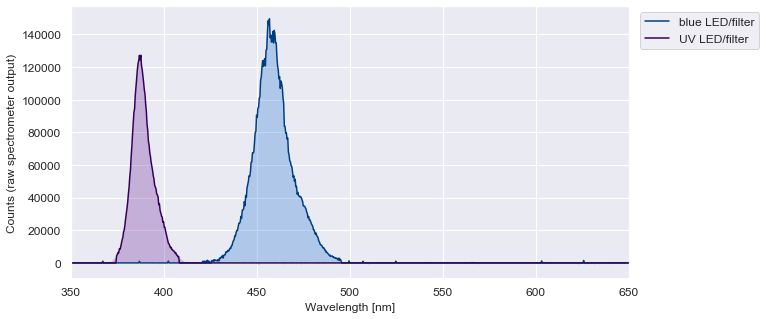

In [38]:
for iLED, LED in enumerate(LEDs):
    col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    
    for iI, Intens in enumerate(stim_intens):
        tempLbl = LED["name"] +" LED/filter" if iI == 0 else ""
        plt.fill(wavelengths, LED["spect_raw_avg"][iI], facecolor=col_hi, alpha=0.25)        
        plt.plot(wavelengths, LED["spect_raw_fit"][iI], color=col_lo, label=tempLbl)
plt.gca().set(xlabel="Wavelength [nm]", ylabel="Counts (raw spectrometer output)")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   
plt.xlim((350, 650))

Now the measured LED/filter spectra are ...  
1. corrected using the calibration data of the spectrometer (in [µJ/s]) and counts are converted  into [nW] (1 µJ/s = 1000 nW),
2. interpolated to match the 300 to 699 nm x scale of the opsin data (-> `spect_nw`), ...  
3. and a copy is made that is normalize to the maximal amplitude (-> `spect`)

In [39]:
for iLED, LED in enumerate(LEDs):
    LED["spect_nw"]      = []
    LED["spect_nw_norm"] = []
    for iI, Intens in enumerate(stim_intens):    
        try:                  
            corrSpect         = np.multiply(LED["spect_raw_fit"][iI], spm_calib_values)*1000 /int_time_s
            corrSpectInterpol = np.interp(x_wavelen_nm, wavelengths, corrSpect)
            _amax             = np.amax(corrSpectInterpol)
            if _amax != 0:
                corrSpectIntNorm  = corrSpectInterpol /_amax
            else:
                tempLbl = LED["name"] +" LED/filter"
                print("WARNING: maximal amplitude is zero for intensity {0} of {1}.".format(Intens, tempLbl))
                raise FloatingPointError

        except FloatingPointError as err:    
            print("ERROR: for {0} LED/filter at {1}, `{2}`.".format(LED["name"], Intens, err))
            corrSpectInterpol = np.zeros((len(x_wavelen_nm),), dtype=np.float64)
            corrSpectIntNorm  = corrSpectInterpol
        
        LED["spect_nw"].append(corrSpectInterpol)
        LED["spect_nw_norm"].append(corrSpectIntNorm) 

Next, the LED/filter spectra need to be corrected for the wavelength-specific transmission through the eye (based on Henriksson et al. Experimental Eye Research 2010). Note that this is only necessary for in vivo recordings. First, the file is loaded and displayed.

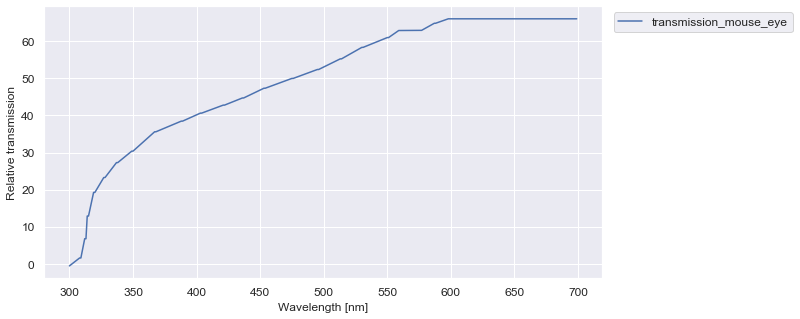

In [40]:
# Load transmission data file
transmission_Name        = "Transmission_mouse_eye"
transmission_mouse_eye   = np.loadtxt(path_Transmission +transmission_Name +".txt", usecols=(0,))
transmission_wavelengths = np.loadtxt(path_Transmission +transmission_Name +".txt", usecols=(1,))
# Disply file
plt.plot(transmission_wavelengths, transmission_mouse_eye, label="transmission_mouse_eye")
plt.gca().set(xlabel="Wavelength [nm]", ylabel="Relative transmission")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   
display.display(plt.gcf())
display.clear_output(wait=True)

Provide the pupil area and estimate the ratio between pupil area and retinal area:

In [41]:
eye_axial_len_mm = 3
ret_area = 0.6 *(eye_axial_len_mm/2)**2 *np.pi *4

# pupil_area = 0.21 # stationary
pupil_area = 1.91 # running

pupil_to_retina = pupil_area/ret_area

print("mouse retinal area [mm²]            = {0:.1f}".format(ret_area))
print("pupil area         [mm²]            = {0:.1f}".format(pupil_area))

mouse retinal area [mm²]            = 17.0
pupil area         [mm²]            = 1.9


Adjust intensity based on eye transmission and pupil size:

In [42]:
for iLED, LED in enumerate(LEDs):
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    LED["spect_nw_corr"] = []    
    for iI, Intens in enumerate(stim_intens):
        current_spectrum = np.multiply(LED["spect_nw"][iI], transmission_mouse_eye)
        current_spectrum/=100
        current_spectrum = current_spectrum
        LED["spect_nw_corr"].append(current_spectrum*pupil_to_retina)

Plot calibrated (fitted) spectra of LED/filter combinations together with the photoreceptor opsin sensitivity curves and the filter spectra from the datasheets:

blue	LED/filter, sum = 6.062e+00
UV	LED/filter, sum = 5.300e+00


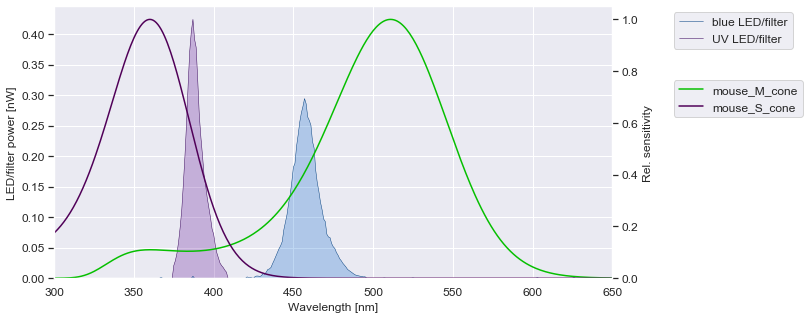

In [43]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for iLED, LED in enumerate(LEDs):
    col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    for iI, Intens in enumerate(stim_intens):    
        tempLbl = LED["name"] +" LED/filter" if iI == 0 else ""
        ax1.plot(x_wavelen_nm, LED["spect_nw_corr"][iI], color=col_lo, label=tempLbl, linewidth=0.5)
        ax1.fill(x_wavelen_nm, LED["spect_nw_corr"][iI], facecolor=col_hi, alpha=0.25)    
    if LEDFilterType != 2:
        ax2.plot(x_wavelen_nm, LED["filter_spect"], color="black", label="Filter_" +LED["name"], linewidth=1)
    
for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        ax2.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

ax1.set_xlabel("Wavelength [nm]")        
ax1.set_ylabel("LED/filter power [nW]")   
ax1.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax1.set_ylim(bottom=0)

ax2.set_ylabel("Rel. sensitivity")        
ax2.legend(bbox_to_anchor=(1.10, 0.75), loc="upper left")
ax2.set_ylim(bottom=0)
ax2.grid(False)
ax2.set_xlim((300, 650))

for iLED, LED in enumerate(LEDs):
    print("{0}\tLED/filter, sum = {1:.3e}".format(LED["name"], np.sum(LED["spect_nw_corr"])))

## Determine effective photoreceptor stimulation

Calculate spectra for effective LED/filter combinations ...

In [44]:
for LED in LEDs:
    LED["effect_on_PR"] = []
    for PR in PRs:
        if len(PR["spect"]) > 0:
            temp = {}
            temp["PR_name"] = PR["name"]
            temp["spect"]   = []
            temp["rel_exc"] = []
            for iI, Intens in enumerate(stim_intens):    
                tempSpect   = np.array(PR["spect"] *LED["spect_nw_norm"][iI])
                temp["spect"].append(tempSpect)
                A_overlap   = np.trapz(tempSpect)
                A_LED       = np.trapz(LED["spect_nw_norm"][iI])
                rel_exc     = A_overlap /A_LED if (A_LED > 0) else 0.0
                temp["rel_exc"].append(rel_exc)
            LED["effect_on_PR"].append(temp)










## Generate summary (maximal isomerization rates)

1. Plot (normalized) spectra of photoreceptors and LED/filter combinations and print relative co-excitation of photoreceptors by the LEDs.

2. Calculate and print photo-isomerization rates for all LED/filter and photoreceptor combinations

Relative co-excitation (at intensity=255):
  42.7% of mouse_M_cone by blue
   0.3% of mouse_S_cone by blue
  10.6% of mouse_M_cone by UV
  52.1% of mouse_S_cone by UV


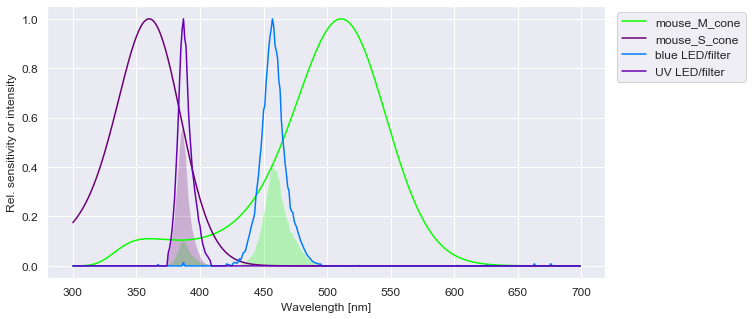

Maximal photoisomerization rates (at intensity=255):
(4227.53996153122, 'mouse_M_cone', 'blue')
    4.2 10^3 photons/s in mouse_M_cone for blue
(25.08357260704248, 'mouse_S_cone', 'blue')
    0.0 10^3 photons/s in mouse_S_cone for blue
(777.7971594857358, 'mouse_M_cone', 'UV')
    0.8 10^3 photons/s in mouse_M_cone for UV
(3818.8818398235026, 'mouse_S_cone', 'UV')
    3.8 10^3 photons/s in mouse_S_cone for UV


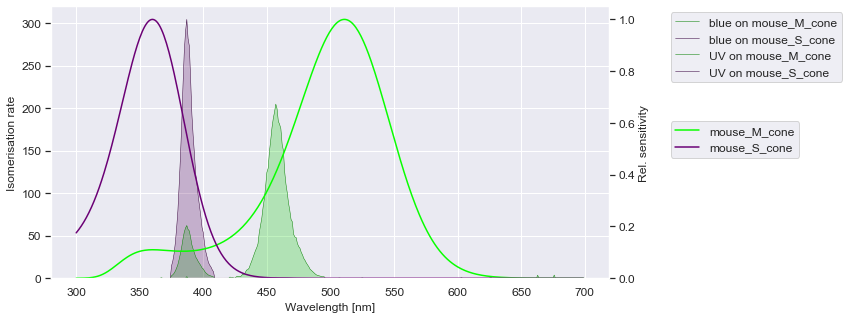

In [45]:
# Plot (normalized) spectra of photoreceptors and LED/filter combinations
#
for PR in PRs:
    if len(PR["spect"]) > 0:
        plt.plot(x_wavelen_nm, PR["spect"], 
                 color=spc.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])
        
for LED in LEDs:        
    colLED = spc.wavelength_to_rgb(LED["peak_nm"])
    if len(LED["spect_nw_norm"][-1]) > 0:    
        plt.plot(x_wavelen_nm, LED["spect_nw_norm"][-1], color=colLED, label=LED["name"] +" LED/filter")
        for effect in LED["effect_on_PR"]:
            for PR in PRs:
                if PR["name"] == effect["PR_name"]:
                    colPR = spc.wavelength_to_rgb(PR["peak_nm"])
            plt.fill(x_wavelen_nm, effect["spect"][-1], facecolor=colPR, alpha=0.25)    

plt.gca().set(xlabel="Wavelength [nm]", ylabel="Rel. sensitivity or intensity")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


# Print co-excitation values for all LED/filter and photoreceptor combinations
#
print("Relative co-excitation (at intensity={0}):".format(stim_intens[-1]))
for LED in LEDs:        
    if len(LED["spect_nw_norm"][-1]) > 0:    
        for effect in LED["effect_on_PR"]:
            print("{0:6.1f}% of {1} by {2}"
                  .format(effect["rel_exc"][-1]*100, effect["PR_name"], LED["name"]))    
plt.show()


# Calculate and print photo-isomerization rates for all LED/filter and 
# photoreceptor combinations
#            
for iLED, LED in enumerate(LEDs):
    LED["pow_eflux"] = []
    LED["pow_Q"]     = []
    LED["pow_phi"]   = []
    LED["pow_E"]     = []
    
    for iI, Intens in enumerate(stim_intens):    
        # Convert energy flux from [nW] (=readout of spectrometer) into [eV/s]
        #
        pow_eflux = np.array((LED["spect_nw_corr"][iI] *1E-9 *eV_per_J), dtype=float)
    
        # Calculate the wavelength-dependent photon energy `Q` in [eV]
        #
        pow_Q     = np.array((c*h/(x_wavelen_nm *1E-9)), dtype=float)
    
        # Divide energy flux by the photon energy to get the photon flux `phi`[photons/s] 
        # and then photon flux density `E` [photons/s /µm^2]
        #
        pow_phi   = np.divide(pow_eflux, pow_Q)
        pow_E     = pow_phi /A_detect_um2
    
        LED["pow_eflux"].append(pow_eflux)
        LED["pow_Q"].append(pow_Q)
        LED["pow_phi"].append(pow_phi)
        LED["pow_E"].append(pow_E)
    
    # Calculate per photoreceptor ...
    #
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                effect["photon_rate"]         = []
                effect["photoiso_rate"]       = []
                effect["photoiso_rate_total"] = []
                
                for iI, Intens in enumerate(stim_intens):    
                    # ... photon flux per photoreceptor `photon_rate` in [photons/s]
                    #
                    A_collect   = PR["collecArea_um2"]
                    photon_rate = LED["pow_E"][iI] *A_collect           
                
                    # ... photoisomerizations [P*/photoreceptor /s]
                    #
                    photoiso_rate       = photon_rate *effect["rel_exc"][iI]
                    photoiso_rate_total = np.sum(photoiso_rate)
                
                    effect["photon_rate"].append(photon_rate) 
                    effect["photoiso_rate"].append(photoiso_rate) 
                    effect["photoiso_rate_total"].append(photoiso_rate_total) 
                
                if (iLED == 0) and (iPR == 0): 
                    print("Maximal photoisomerization rates (at intensity={0}):".format(stim_intens[-1]))
               
                print((effect["photoiso_rate_total"][-1], PR["name"], LED["name"])) 
                print("{0:7.1f} 10^3 photons/s in {1} for {2}"
                      .format(effect["photoiso_rate_total"][-1]/1E3, PR["name"], LED["name"]))

# Plot ...
#
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for PR in PRs:
    if len(PR["spect"]) > 0:
        ax2.plot(x_wavelen_nm, PR["spect"], 
                 color=spc.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])

for LED in LEDs:
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_hi = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.8)
                ax1.plot(x_wavelen_nm, effect["photoiso_rate"][-1], color=col_lo, 
                         label=LED["name"] +" on " +PR["name"], linewidth=0.5)
                ax1.fill(x_wavelen_nm, effect["photoiso_rate"][-1], facecolor=col_hi, alpha=0.25)        

ax1.set_xlabel("Wavelength [nm]")        
ax1.set_ylabel("Isomerisation rate")   
ax1.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax1.set_ylim(bottom=0)

ax2.set_ylabel("Rel. sensitivity")        
ax2.legend(bbox_to_anchor=(1.10, 0.60), loc="upper left")
ax2.set_ylim(bottom=0)
ax2.grid(False)   